
<a id='parallel'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Numba vs NumPy vs JAX

**John Stachurski** Sept 2023

[NumPy](https://numpy.org/) is a legacy Python library using pre-compiled code for array operations

[Numba](https://numba.pydata.org/) is a modern JIT compiler built on LLVM

[JAX](https://github.com/google/jax) is an "open source" Google project that combines 

* NumPy style array processing
* a highly efficient JIT-compiler for array operations
* automatic differentiation
* the ability to specialize JIT-compiled code for CPUs / GPUs / TPUs

In general

* Numba is better for purely sequential single threaded tasks
* JAX is better for parallelizable / array processing
* NumPy is old-school but still convenient

JAX almost always dominates NumPy in performance.

## How to run this lecture

You can run this lecture on your laptop / desktop CPU if you install Anaconda Python + JAX for the CPU.  Uncomment what you need:

In [20]:
#!pip install jax[CPU]"

However, the real benefit of JAX comes with GPU access.

The easiest way to get this is to 

- open this notebook on Google Colab
- select "Notebook settings" and then add a GPU

We begin by importing some libraries that will be discussed below.

In [28]:
import numpy as np
from numpy.random import randn
import numba 
from numba import njit, vectorize, float64
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from time import time

## Multivariate Optimization

The problem is to maximize the function 

$$ f(x, y) = \frac{\cos \left(x^2 + y^2 \right)}{1 + x^2 + y^2} + 1$$

using brute force --- searching over a grid of $(x, y)$ pairs.

In [29]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

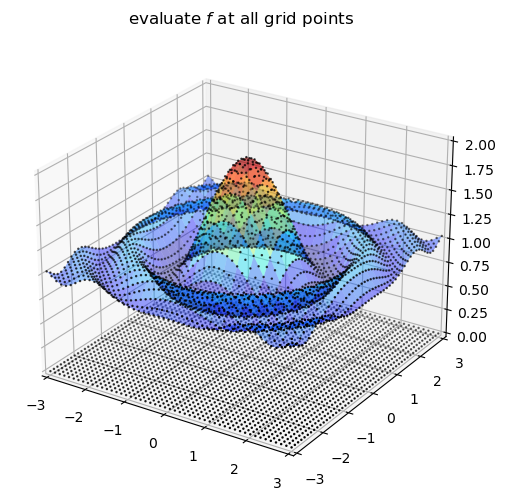

In [30]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

gridsize = 50
gmin, gmax = -3, 3
xgrid = np.linspace(gmin, gmax, gridsize)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

# === plot value function === #
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.4,
                linewidth=0.05)

ax.set_title("evaluate $f$ at all grid points")
ax.scatter(x, y, c='k', s=0.6)

ax.scatter(x, y, f(x, y), c='k', s=0.6)

ax.view_init(25, -57)
ax.set_zlim(-0, 2.0)
ax.set_xlim(gmin, gmax)
ax.set_ylim(gmin, gmax)

plt.show()

For the grid size we set 

In [31]:
n = 10_000

Let's try a few different methods to make it fast.

### Vectorized Numpy

In [36]:
grid = np.linspace(-3, 3, num=n)

x, y = np.meshgrid(grid, grid)

In [41]:
start = time()
out = np.max(f(x, y))
stop = time()

In [48]:
numpy_time = stop - start
print(f"NumPy execution time = {numpy_time} seconds")

NumPy execution time = 1.1905651092529297 seconds


### JITTed code


A jitted version

In [49]:
@numba.njit 
def compute_max():
    m = -np.inf
    for x in grid:
        for y in grid:
            z = np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1
            if z > m:
                m = z
    return m

In [44]:
compute_max()

1.999999819964011

In [45]:
start = time()
out = compute_max()
stop = time()

In [50]:
numba_loops_time = stop - start
print(f"Numba loops time = {numba_loops_time} seconds")

Numba loops time = 1.1905651092529297 seconds


Why is that faster than NumPy's highly optimized pre-compiled code???

### Vectorized Numba on the CPU


We can use some tricks to add CPU-based parallelization via Numba.

In [63]:
@vectorize('float64(float64, float64)', target='parallel')
def f_par(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1


In [64]:
x, y = np.meshgrid(grid, grid)

np.max(f_par(x, y))

1.999999819964011

In [65]:
start = time()
out = np.max(f_par(x, y))
stop = time()

In [66]:
numba_vectorized_time = stop - start
print(f"Vectorized Numba time = {numba_vectorized_time} seconds")

Vectorized Numba time = 0.18055057525634766 seconds


### JAX on the GPU

Now let's try JAX.

This code will work well if you have a GPU and JAX configured to use it.

Let's see what we have available.

In [67]:
!nvidia-smi

No devices were found


#### Replacing NumPy with JAX

For this step we replace `np` with `jnp`, which is our alias for `jax.numpy`

Warning --- you need a GPU with relatively large memory for this to work.

In [68]:
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

In [69]:
grid = np.linspace(-3, 3, 10000)

x, y = jnp.meshgrid(grid, grid)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Here's our timing.

In [73]:
start = time()
jnp.max(f(x, y)).block_until_ready()
stop = time()

(Here `block_until_ready()` handles asynchronous execution.)

In [75]:
jax_v1_time = stop - start
print(f"JAX V1 time = {jax_v1_time}")

JAX V1 time = 1.1243724822998047


#### JIT Compiling the Function

Let's JIT-compile the function and see if anything changes.

In [76]:
f = jax.jit(f)

With compile time:

In [78]:
%%time

jnp.max(f(x, y))

CPU times: user 1.11 s, sys: 151 ms, total: 1.26 s
Wall time: 654 ms


Array(1.9999998, dtype=float32)

In [79]:
start = time()
out = jnp.max(f(x, y)).block_until_ready()
stop = time()

In [80]:
jax_v2_time = stop - start
print(f"JAX V2 time = {jax_v2_time}")

JAX V2 time = 0.6596996784210205


Total speed gain over NumPy:

In [82]:
numpy_time / jax_v2_time

1.8047077301940273

## Monte Carlo


We wish to compute the mean of

$$
    S = (X_1 + X_2 + X_3)^p
$$

We assume that

* $p$ is a positive number, which is known to us,
* $X_i \sim LN(\mu_i, \sigma_i)$ for $i=1,2,3$,
* the values of $\mu_i, \sigma_i$ have all been estimated, and
* the random variables $X_1$, $X_2$ and $X_3$ are independent.

How should we compute the mean of $S$?

To do this with pencil and paper is hard (unless, say, $p=1$).

Instead we use Monte Carlo:

1. Generate $n$ independent draws of $X_1$, $X_2$ and $X_3$ on a computer,
1. Use these draws to generate $n$ independent draws of $S$, and
1. Take the average value of these draws of $S$.

By the law of large numbers, this average will be close to the true mean when
$n$ is large.

We use the following values for $p$ and each $\mu_i$ and $\sigma_i$.

In [ ]:
n = 10_000_000
p = 0.5
μ_1, μ_2, μ_3 = 0.2, 0.8, 0.4
σ_1, σ_2, σ_3 = 0.1, 0.05, 0.2

### A Vectorized Routine with NumPy

Now we implement a vectorized routine using traditional NumPy array processing.

In [ ]:
def compute_mean_vectorized(n=10_000_000):
    X_1 = np.exp(μ_1 + σ_1 * randn(n))
    X_2 = np.exp(μ_2 + σ_2 * randn(n))
    X_3 = np.exp(μ_3 + σ_3 * randn(n))
    S = (X_1 + X_2 + X_3)**p
    return(S.mean())

In [ ]:
%%time

compute_mean_vectorized()

### Using Google JAX


Let's try to shift this to the GPU and parallelize it effectively.

In [ ]:
!nvidia-smi

In [ ]:
def compute_mean_jax(n=10_000_000):
    key = jax.random.PRNGKey(1)
    Z = jax.random.normal(key, (3, n))
    X_1 = jnp.exp(μ_1 + σ_1 * Z[0,:])
    X_2 = jnp.exp(μ_2 + σ_2 * Z[1,:])
    X_3 = jnp.exp(μ_3 + σ_3 * Z[2,:])
    S = (X_1 + X_2 + X_3)**p
    return(S.mean())

In [ ]:
%%time

compute_mean_jax()

In [ ]:
compute_mean_jax_jitted = jax.jit(compute_mean_jax)

In [ ]:
%%time

compute_mean_jax_jitted()

In [ ]:
%%time

compute_mean_jax_jitted()